# Backtesting

In this section, we construct a backtest using industry data. More precisely, we use data from Ken French's data library to construct a simple industry momentum return predictor.

The goal of a backtest is to assess the validity of a trading predictor at any point in the past. In particular, it is crucial to avoid any forward-looking bias -- in which information available only after time $t$ is mistakingly used at time $t$. In practice, the predictors are estimated over `rolling` (or `expanding`) windows. We implement rolling window estimation with the `sklearn` `TimeSeriesSplit` object.

To validate a backtest, there are several steps: 

1. reasonability of the rationale (why it might/should work); 
2. predictability (e.g. statistical significance of the predictor over time and across assets); 
3. robustness (does the statistical significance survive perturbations); 
4. tradability (does the statistical significance survive cost). 


For backtesting, visualisation is very important and we make use of some plotting functions introduced in the Appendix:

In [1]:
from skfin.backtesting import Backtester

In [2]:
from skfin.plot import bar, heatmap, line

## Industry momentum backtest 

The setup for predicting industry returns is the following: 

- the assets are industries; 

- the return forecast $\alpha$ is estimated using rolling-window returns (over $L$ months, $L=12$) preceding a given date; 

-  no `look-ahead bias`: at each date, only information up that date is used; 

- such a strategy goes long past "winners" (industries with higher-than-average returns) and goes short "losers" (industries with lower-than-average returns) $\Rightarrow$ Momentum strategy; 

- this strategy is often implemented by skipping the most recent month to avoid the `1-month reversal" effect`. 

The article "Do Industries Explain Momentum" (1999) by  Moskowitz and Grinblatt  in the  *Journal of Finance* document that indeed there is momentum in industry returns -- past industry returns help predict statistically and economically future industry returns. 

In [3]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
from IPython.display import Image, display

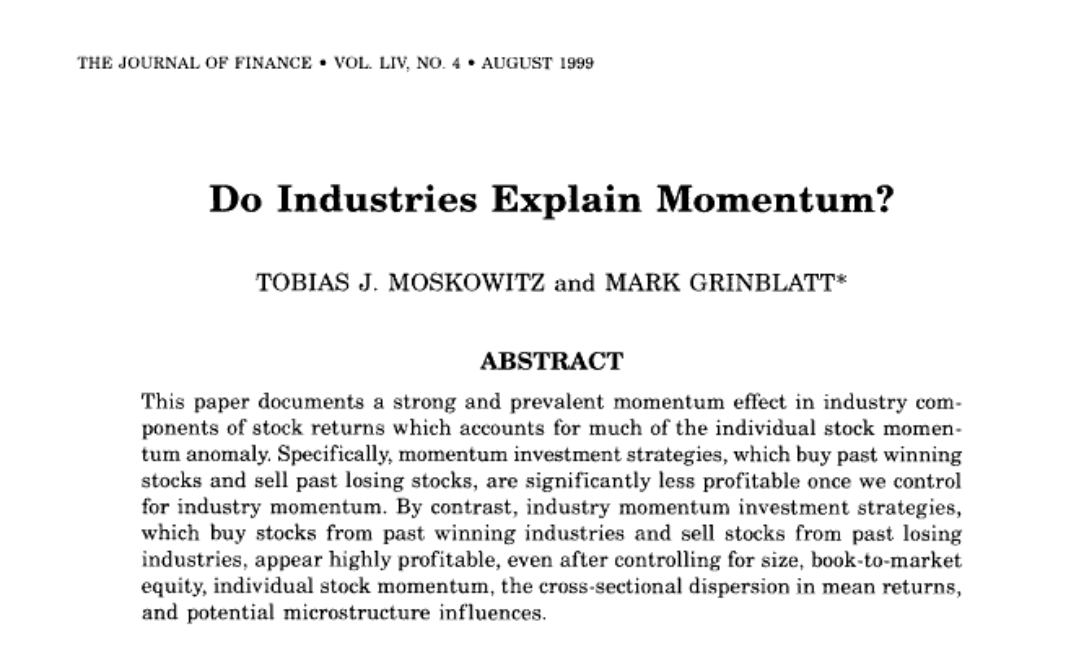

In [4]:
# hide
display(Image("images/l2_grinblatt_header.png", width=600))

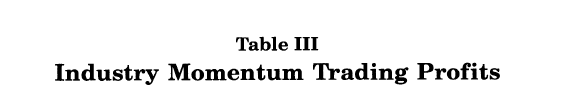

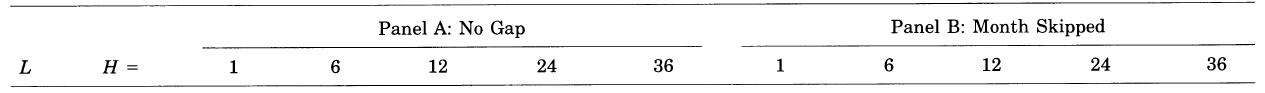

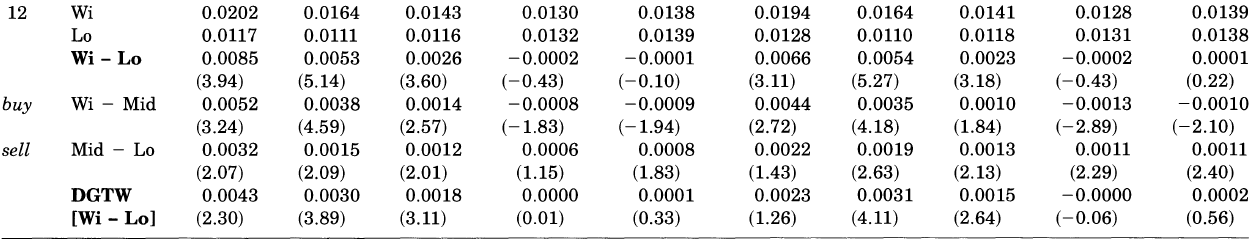

In [5]:
# hide
display(Image("images/l2_grinblatt_table3heading.PNG", width=600))
display(Image("images/l2_grinblatt_table3heading2.PNG", width=800))
display(Image("images/l2_grinblatt_table3.PNG", width=800))

### Industry data

To load the data, we use the function `load_kf_returns` introduced in the `Data` section: 

In [6]:
from skfin.datasets_ import load_kf_returns

returns_data = load_kf_returns(cache_dir="data", force_reload=False)

INFO:skfin.dataloaders.cache:Loading from cache : data/12_Industry_Portfolios


Since the Moskowitz-Grinblatt paper was published in August 1999, we will keep the data after 1999 as `out-of-sample` and only use the data before 1999. 

In [7]:
ret = returns_data["Monthly"]["Average_Value_Weighted_Returns"][:"1999"]

### Backtesting functions

In the next set of helper file, we introduce the main `Backtester` class and the `fit_and_predict` function to run rolling window estimations. 

In [8]:
%%writefile ../skfin/backtesting.py
from dataclasses import dataclass

import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from skfin.mv_estimators import MeanVariance
from sklearn.base import BaseEstimator, clone
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils.metaestimators import _safe_split


def compute_pnl(h, ret, pred_lag):
    pnl = h.shift(pred_lag).mul(ret)
    if isinstance(h, pd.DataFrame):
        pnl = pnl.sum(axis=1)
    return pnl


def fit_predict(estimator, X, y, train, test, return_estimator=True):
    X_train, y_train = _safe_split(estimator, X, y, train)
    X_test, _ = _safe_split(estimator, X, y, test, train)
    estimator.fit(X_train, y_train)
    if return_estimator:
        return estimator.predict(X_test), estimator
    else:
        return estimator.predict(X_test)


@dataclass
class Backtester:
    estimator: BaseEstimator = MeanVariance()
    max_train_size: int = 36
    test_size: int = 1
    pred_lag: int = 1
    start_date: str = "1945-01-01"
    end_date: str = None
    name: str = None

    def compute_holdings(self, X, y, pre_dispatch="2*n_jobs", n_jobs=1):
        X = X.loc[:self.end_date]
        cv = TimeSeriesSplit(
            max_train_size=self.max_train_size,
            test_size=self.test_size,
            n_splits=1 + len(X.loc[self.start_date : ]) // self.test_size,
        )
        parallel = Parallel(n_jobs=n_jobs, pre_dispatch=pre_dispatch)
        res = parallel(
            delayed(fit_predict)(
                clone(self.estimator), X.values, y.values, train, test, True
            )
            for train, test in cv.split(X)
        )
        y_pred, estimators = zip(*res)
        idx = X.index[np.concatenate([test for _, test in cv.split(X)])]
        if isinstance(y, pd.DataFrame):
            cols = y.columns
            h = pd.DataFrame(np.concatenate(y_pred), index=idx, columns=cols)
        elif isinstance(y, pd.Series):
            h = pd.Series(np.concatenate(y_pred), index=idx)
        else:
            h = None
        self.h_ = h
        self.estimators_ = estimators
        self.cv_ = cv
        return self

    def compute_pnl(self, ret):
        pnl = compute_pnl(self.h_, ret, self.pred_lag)
        self.pnl_ = pnl.loc[self.start_date : self.end_date]
        if self.name:
            self.pnl_ = self.pnl_.rename(self.name)
        return self

    def train(self, X, y, ret):
        self.compute_holdings(X, y)
        self.compute_pnl(ret)
        return self.pnl_

Overwriting ../skfin/backtesting.py


In [9]:
from skfin.backtesting import Backtester
from skfin.mv_estimators import MeanVariance

### Scikit-Learn TimeSeriesSplit

In [10]:
from sklearn.model_selection import TimeSeriesSplit

Given that the data is monthly, we re-estimate the model every month. This is done by choosing the parameter `n_splits` in the class `TimeSeriesSplit` as the number of months. 

In [11]:
start_date = "1945-01-01"
test_size = 1
params = dict(max_train_size=36, test_size=test_size, gap=0)
params["n_splits"] = 1 + len(ret.loc[start_date:]) // test_size

cv = TimeSeriesSplit(**params)

More precisely, with `TimeSeriesSplit`:

- the `test` indices are the dates for which the holdings are computed.

- the `train` indices are the date range over which a forecasting model is trained.

- the target will been shifted by $-1$ and `gap` is set to 0. 

- we can estimate batches with `test_size` > 1.

- `n_splits` is determined so that the backtest starts (just) before a certain start date.

In [12]:
for train, test in cv.split(ret):
    break
ret.iloc[train].index[-1].strftime("%Y%m%d"), ret.iloc[test].index[0].strftime("%Y%m%d")

('19441101', '19441201')

## Empirical results

### Cumulative pnl

We first define two transform functions: 

- `transform_X` computes the main feature  (or `predictor`) as the average of the trailing 12-month returns; 
- `transform_y` is applied on the returns -- here when passed to the mean-variance `MeanVariance` class to compute the covariance matrix; but more generally to serve as a target for predictors with machine-learning. 

In [13]:
def transform_X(df, window=12):
    return df.rolling(window=window).mean()


def transform_y(df):
    return df.shift(-1)


X = transform_X(ret)
y = transform_y(ret)

In [14]:
_h = []
for train, test in cv.split(ret):
    m = MeanVariance()
    m.fit(X.values[train], y.values[train])
    _h += [m.predict(X.values[test])]

cols = ret.columns
idx = ret.index[np.concatenate([test for _, test in cv.split(ret)])]
h = pd.DataFrame(np.concatenate(_h), index=idx, columns=cols)

Note that the `line` plotting function shows the sharpe ratio "sr" of the strategy. 

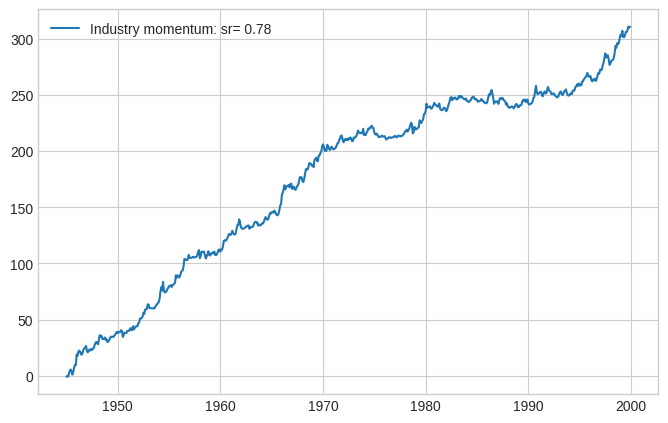

In [15]:
pnl = h.shift(1).mul(ret).sum(axis=1)[start_date:].rename("Industry momentum")
line(pnl, cumsum=True, loc="best")

We can also use the `Backtester` class and we test that the two approaches yield the same result.

In [16]:
m = Backtester(estimator=MeanVariance(), name="Industry momentum")
pnl_ = m.train(X, y, ret)

In [17]:
assert np.allclose(h, m.h_)
assert np.allclose(pnl, m.pnl_)

### Other backtest statistics 

We can also extract information for the estimator -- e.g. in this simple case, recover the covariance matrix fitted by the class `MeanVariance()`.

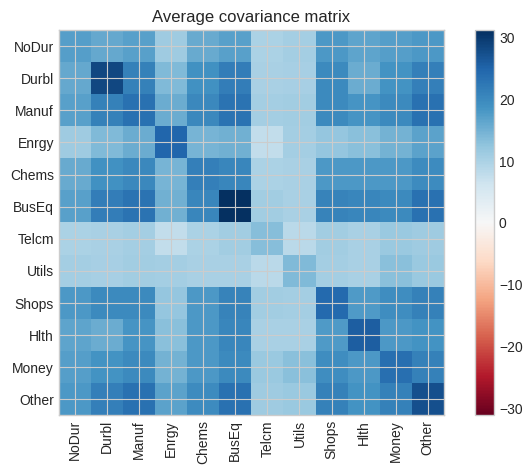

In [18]:
estimators = m.estimators_
V_mean = pd.DataFrame(
    sum([m.V_ for m in estimators]) / len(estimators),
    index=ret.columns,
    columns=ret.columns,
)
heatmap(V_mean, title="Average covariance matrix")

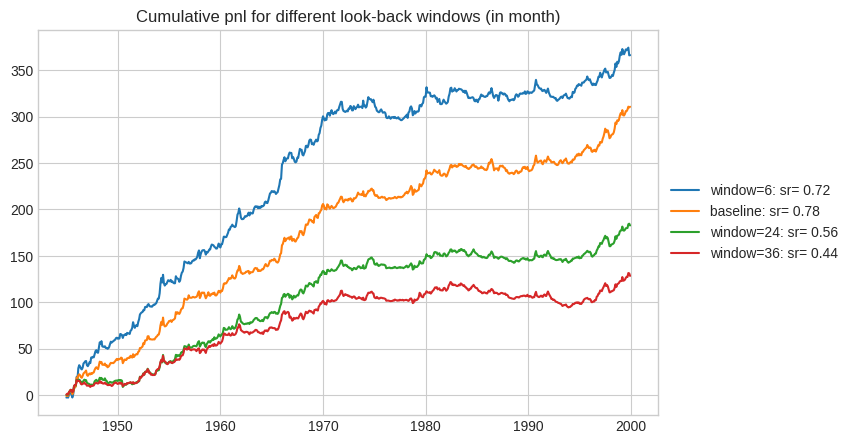

In [19]:
pnls = []
for window in [6, 12, 24, 36]:
    X_ = ret.rolling(window).mean()
    name = f"window={window}" if window != 12 else "baseline"
    pnls += [Backtester(estimator=MeanVariance(), name=name).train(X_, y, ret)]
title = "Cumulative pnl for different look-back windows (in month)"
line(pd.concat(pnls, axis=1), cumsum=True, start_date="1945", title=title)

The following graph shows the `lead-lag sharpe ratio` plot for the industry momentum backtest: 
    
- the horizon "0" (green bar) represents the sharpe ratio of the tradable pnl; 
- the lagged horizons (with positive coordinates) show the performance when the positions are lagged by several months and illustrates the `alpha decay` of the predictor; 
- the lead horizons (with negative coordinates) represent the non-tradable counterfactual performance if the information had been available earlier. 

For `trending` predictors (like the industry momentum backtest), the lead sharpe ratios are very high and the alpha decay is quite fast. For `contrarian` predictors, the lead sharpe ratios are negative. 

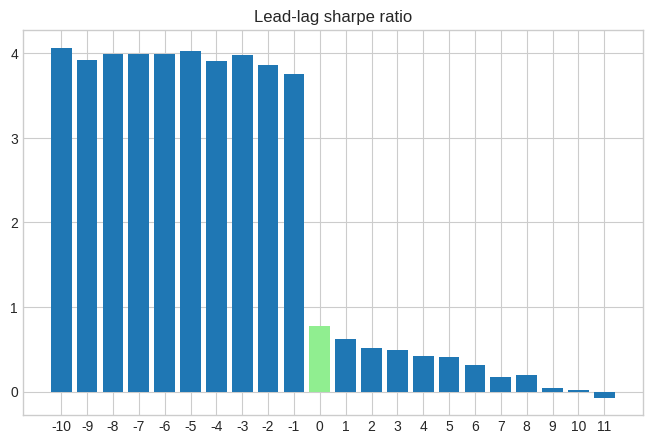

In [20]:
from skfin.metrics import sharpe_ratio

sr = {i: h.shift(1 + i).mul(ret).sum(axis=1).pipe(sharpe_ratio) for i in range(-10, 12)}
bar(sr, baseline=0, sort=False, title="Lead-lag sharpe ratio")

The `off-the-top` approach is to remove an asset from the tradable set and check whether the portfolio sharpe ratio decreases (in which case, this asset is a *contributor*) or increases (in which case, this asset is a *detractor*).

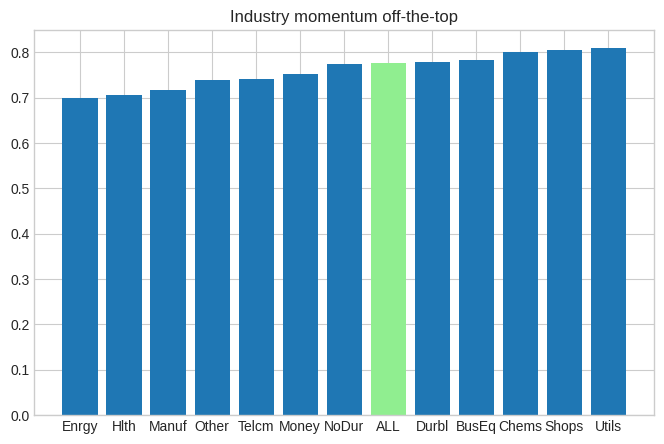

In [21]:
pnls_ott = {}
for c in ret.columns:
    ret_ = ret.drop(c, axis=1)
    X_ = transform_X(ret_)
    y_ = transform_y(ret_)
    pnls_ott[c] = (
        Backtester(estimator=MeanVariance()).train(X_, y_, ret_).pipe(sharpe_ratio)
    )
pnls_ott["ALL"] = pnl.pipe(sharpe_ratio)
bar(pnls_ott, baseline="ALL", title="Industry momentum off-the-top")